**1.   Importation des bibliothèques.**

In [149]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from river import stream
from river import linear_model
from river import optim
from river import preprocessing
from river import time_series
from river import compose
import mysql.connector
from mysql.connector import Error
import calendar
import datetime as dt
import math
from river import metrics
import matplotlib.pyplot as plt
import seaborn as sns


**2.   Lecture des données.**

In [161]:
try:
    connection = mysql.connector.connect(host='127.0.0.1',
                                         database='work',
                                         user='root',
                                         password='0000')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("SELECT * FROM work.biomol;")
        data = cursor.fetchall()
        
        cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'biomol';")
        columns = cursor.fetchall()
except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("MySQL connection is closed")
columns = [column[0] for column in columns]
data = pd.DataFrame(data,columns =columns)

Connected to MySQL Server version  5.5.5-10.6.5-MariaDB
MySQL connection is closed


In [162]:
data

,numtra,patuuid,hospuuid,patsex,codepostal,patage,datent,dursej,deces,datdem,udsdem,etab,pole,libelle,nature,analyse,id_analyse,result
0,0012502109,3a1a7e9a-57b9-5abc-94b1-457cbc99729e,1ea1a45a-9791-5c6b-80f2-8463d7a5edd7,F,13015,88,2019-12-31,7.0,0,2020-01-01,2380,7,4,ACCUEIL URGENCES ADULTES-HN,Ecouvillon,None,QVRSB,POS
1,0012502113,3cceb16b-1a0e-5dab-a679-e9ae64017676,8c069b18-b162-5211-b3f2-6bdbc2b8ef55,M,13700,1,2019-12-31,2.0,0,2020-01-01,3280,7,13,ACCUEIL URGENCES MED.ENFANTS-HN,Asp.nas.ph,None,QVRSB,POS
2,0012502122,e83c6573-65d3-5fee-891a-9f7dfb2b8182,156d1f4d-e088-5c39-a421-3d14169fd8d7,M,84300,0,2019-12-31,3.0,0,2020-01-01,1108,8,13,ACCUEIL URGENCES-TE,Ec.Pharynx,None,QVRSB,POS
3,0012502124,46e09125-9b89-51c7-abcc-c4e63c30e4b2,585c719b-539c-5d9f-a992-94ef58e983fd,M,13016,0,2019-12-31,7.0,0,2020-01-01,3280,7,13,ACCUEIL URGENCES MED.ENFANTS-HN,Asp.nas.ph,None,QVRSB,POS
4,0012502194,f6428500-4f5e-5d65-8ed4-3b7c38ca9185,0b450086-5b4d-5170-b948-7765710387e3,F,13014,33,2020-01-01,5.0,0,2020-01-01,1835,7,2,URGENCES OBSTETRIQUE (MAGES)-HN,Pvt vagin,Streptocoque B,QSTBR,POS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466763,9122584065,435fdf39-02fa-5fd0-8c85-6995b6784dd2,86567375-8067-4476-9c7b-5ad1daecc1e5,F,None,60,2020-01-27,NaN,0,2020-01-27,8149,1,8,RECEPTION-IHU,Lame paraf,None,QBAS,POS
466764,9122587281,1f8452fc-16f3-5cdb-af33-be431d5c7506,275291b2-9248-4d92-aed0-04c15a4c5abf,F,None,71,2020-01-28,NaN,0,2020-01-28,5560,7,16,HOSPIT.ONCO.DIAG.MAL PLEVRE-HN,Lame paraf,None,QUNBL,POS
466765,9122690424,7f41378e-4215-5d6d-84c5-198a2e99ef0c,69d0cd5a-0860-593d-a880-9fe6fe6d673c,F,13005,24,2020-02-27,1.0,0,2020-02-27,POITIE,None,None,None,Sérum,Coxiella burnetii,QCBUR,POS
466766,9122809066,4f770957-944b-52b9-9ad3-199880a46a30,abee4bcb-3b1a-5c99-b0f0-4b0d30e33e4e,F,13330,38,2020-03-30,1.0,0,2020-03-30,3765,7,2,HOP.JOUR DIAGNOSTIC PRENATAL-HN,Sérum,EBV,QEBNL,POS


In [163]:
data.shape

(466768, 18)

**3.   Nettoyage des données.**

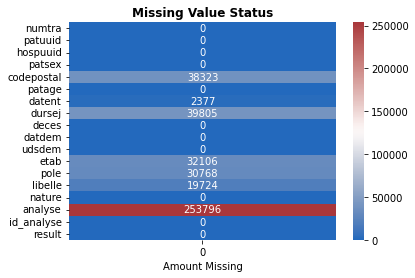

In [164]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

In [165]:
#suppretion des valeurs null
data.dropna(inplace=True)

**4.   Prétraitement.**

<AxesSubplot:ylabel='patsex'>

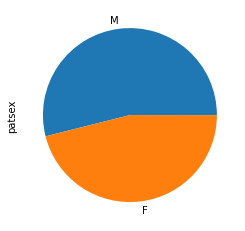

In [166]:
#sexe des patients 
data['patsex'].value_counts().plot.pie()

<AxesSubplot:ylabel='analyse'>

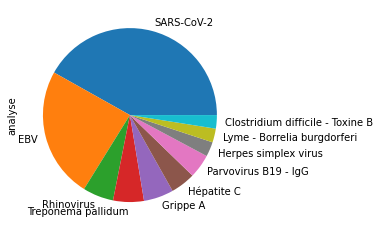

In [167]:
#top 10 des types d'analyses 
data['analyse'].value_counts()[:10].plot.pie()

In [168]:
# Choisir seulement le prelevement du covid
data = data[(data['id_analyse']=='QPCOR') | (data['id_analyse']=='QF229') | (data['id_analyse']=='QFKU1') | (data['id_analyse']=='QC63F') | (data['id_analyse']=='QFC43')]

Text(0, 0.5, 'Nombre de cas')

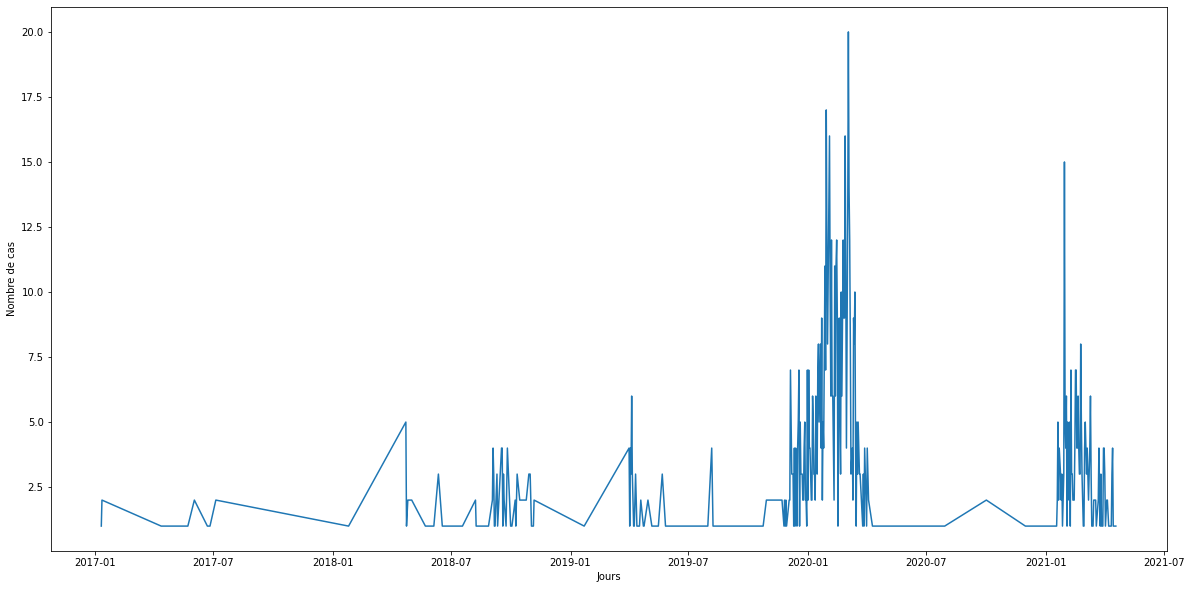

In [169]:
# Nombre de cas par jours
data = data[['datdem','result']].groupby(['datdem']).count().reset_index()
data.columns = ['date','nombre de cas']
data['date'] = pd.to_datetime(data['date'])
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['nombre de cas'])
plt.xlabel('Jours')
plt.ylabel('Nombre de cas')

In [ ]:
# Il y'a un manque de données qui nous a dirigé vers le regroupement par mois

Text(0, 0.5, 'Nombre de cas')

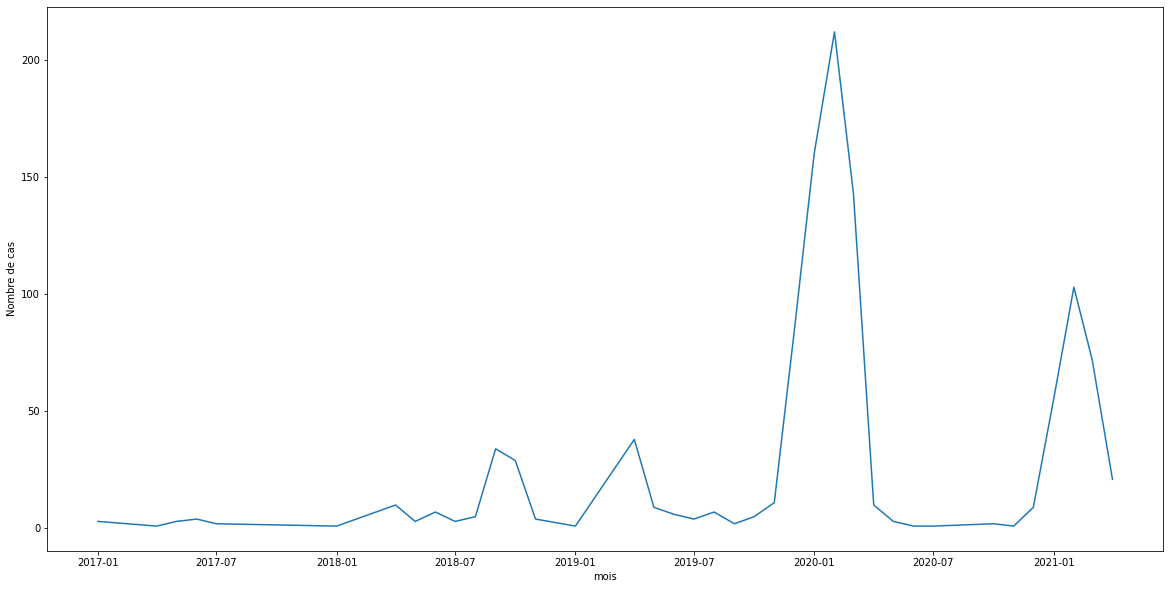

In [170]:
# Nombre de cas par mois
per = data['date'].dt.to_period("M")
g = data.groupby(per)
data = g.sum()
data = data.reset_index()
date = pd.concat([data['date'].dt.year,  data['date'].dt.month,pd.Series([1 for i in range(len(data['date']))])], join = 'outer', axis = 1)
date.columns = ['year','month','day']
date = pd.to_datetime(date[["year", "month", "day"]])
data['date'] = date
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['nombre de cas'])
plt.xlabel('mois')
plt.ylabel('Nombre de cas')

**4.   prediction.**

In [171]:
#prediction
def get_month_distances(x):
    return {
        calendar.month_name[month]: math.exp(-(pd.to_datetime(x['date']).month - month) ** 2)
        for month in range(1, 13)
    }

extract_features = compose.TransformerUnion(
    get_month_distances
)

model = (
    extract_features |
    time_series.SNARIMAX(
        p=0,
        d=0,
        q=0,
        m=1,
        sp=3,
        sq=6,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    )
)

metric = metrics.Rolling(metrics.MAE(), 12)

X = data.copy()
Y = X.pop('nombre de cas')
for x, y in stream.iter_pandas(X,Y):
    y_pred = model.forecast(horizon=1, xs=[x])
    model = model.learn_one(x, y)
    metric = metric.update(y, y_pred[0])

print(metric)

horizon = 12
future = [
    {'date': dt.date(year=2021, month=m, day=1)}
    for m in range(1, horizon + 1)
]
forecast = model.forecast(horizon=horizon, xs=future)
predicted_data = []
for x, y_pred in zip(future, forecast):
    print(x['date'], f'{y_pred:.0f}')
    predicted_data.append([x['date'],f'{y_pred:.0f}'])
predicted_data = pd.DataFrame(predicted_data, columns=['date', 'nombre de cas'])

MAE: 33.042248	(rolling 12)
2021-01-01 96
2021-02-01 115
2021-03-01 65
2021-04-01 21
2021-05-01 12
2021-06-01 20
2021-07-01 29
2021-08-01 37
2021-09-01 40
2021-10-01 38
2021-11-01 49
2021-12-01 65
